# WDL 2022
## Challenge 02
*Optimization of public transport routes during road interruptions*

**Cristian Castro Álvarez**

**Comments**:
- mnivp: 
    - Dataset with public interventions between 2014 and 2021, with a total of 6617 registers
    - 31 interventions don't have "Start" date data
    - 28 interventions don't have "End" date data
    - 54 points have end date before start date. We are going to assume that this is a typo, and invert them.
    - Interventions without start and end dates were deleted (31 points)
    - Columnas 'Temporary reception', 'Final reception' and 'Process number' were deleted for having more than 10% missing values.
    - Interventions without street names were deleted (56 points)
    - We are only concentrating on streets, we won't care about the numbering of the interventions
- eixodevia: Routes axes
- mncautocarro: Bus routes
- names of the streets has portuguese characters that must be changed

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import sys
np.set_printoptions(threshold=sys.maxsize)
import seaborn as sns

import shapely.geometry
import geopandas as gpd
import contextily as cx

import gtfsutils
import gtfsutils.routes
import gtfsutils.filter

## Data

In [2]:
# Interventions data
mnivp = pd.read_csv('mnivp.csv', 
                    sep = ';',
                    header = 0,
                    names = ['id',
                             'applicant',
                             'type of working',
                             'street',
                             'county',
                             'actualization',
                             'start',
                             'end',
                             'process number',
                             'status',
                             'temporary reception',
                             'year',
                             'final reception']
                   )
mnivp.head()

,id,applicant,type of working,street,county,actualization,start,end,process number,status,temporary reception,year,final reception
0,44611945,Particular,Rede eletrica,Rua das Amendoeiras,U.F. Carcavelos e Parede,02-06-2020 09:15,24-04-2020,24-04-2020,WW227609,Em execucao,NaN,2020,NaN
1,44522015,Particular,Rede eletrica,Rua do Bugio,U.F. Carcavelos e Parede,06-04-2020 13:20,14-04-2020,13-04-2020,WW226781,Em execucao,NaN,2020,NaN
2,44514495,Particular,Rede eletrica,Rua das Amendoeiras,U.F. Carcavelos e Parede,12-03-2020 09:38,16-03-2020,20-03-2020,WW224828,Em execucao,NaN,2020,NaN
3,46640212,Particular,Rede eletrica,"Travessa Nuno Tristao, n.1 em Murches",Alcabideche,11-05-2021 15:52,18-05-2021,19-05-2021,WW272199,Em execucao,NaN,2021,NaN
4,40717062,ADC aguas de Cascais,Rede eletrica,Caminho do Uruguai,Alcabideche,24-01-2018 12:13,29-01-2018,09-02-2018,IVP/0009/18,Em execucao,12-02-2018,2018,12-02-2021


In [3]:
mnivp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6617 entries, 0 to 6616
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   6617 non-null   int64 
 1   applicant            6617 non-null   object
 2   type of working      6617 non-null   object
 3   street               6561 non-null   object
 4   county               6561 non-null   object
 5   actualization        6617 non-null   object
 6   start                6596 non-null   object
 7   end                  6599 non-null   object
 8   process number       4764 non-null   object
 9   status               6617 non-null   object
 10  temporary reception  1480 non-null   object
 11  year                 6614 non-null   object
 12  final reception      1483 non-null   object
dtypes: int64(1), object(12)
memory usage: 672.2+ KB


In [4]:
# Change dates to datetime
mnivp['start'] = pd.to_datetime(mnivp['start'].astype(str), format = '%d-%m-%Y', errors = 'coerce')
mnivp['end'] = pd.to_datetime(mnivp['end'].astype(str), format = '%d-%m-%Y', errors = 'coerce')
mnivp.info()
mnivp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6617 entries, 0 to 6616
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   6617 non-null   int64         
 1   applicant            6617 non-null   object        
 2   type of working      6617 non-null   object        
 3   street               6561 non-null   object        
 4   county               6561 non-null   object        
 5   actualization        6617 non-null   object        
 6   start                6586 non-null   datetime64[ns]
 7   end                  6589 non-null   datetime64[ns]
 8   process number       4764 non-null   object        
 9   status               6617 non-null   object        
 10  temporary reception  1480 non-null   object        
 11  year                 6614 non-null   object        
 12  final reception      1483 non-null   object        
dtypes: datetime64[ns](2), int64(1), o

,id,applicant,type of working,street,county,actualization,start,end,process number,status,temporary reception,year,final reception
0,44611945,Particular,Rede eletrica,Rua das Amendoeiras,U.F. Carcavelos e Parede,02-06-2020 09:15,2020-04-24,2020-04-24,WW227609,Em execucao,NaN,2020,NaN
1,44522015,Particular,Rede eletrica,Rua do Bugio,U.F. Carcavelos e Parede,06-04-2020 13:20,2020-04-14,2020-04-13,WW226781,Em execucao,NaN,2020,NaN
2,44514495,Particular,Rede eletrica,Rua das Amendoeiras,U.F. Carcavelos e Parede,12-03-2020 09:38,2020-03-16,2020-03-20,WW224828,Em execucao,NaN,2020,NaN
3,46640212,Particular,Rede eletrica,"Travessa Nuno Tristao, n.1 em Murches",Alcabideche,11-05-2021 15:52,2021-05-18,2021-05-19,WW272199,Em execucao,NaN,2021,NaN
4,40717062,ADC aguas de Cascais,Rede eletrica,Caminho do Uruguai,Alcabideche,24-01-2018 12:13,2018-01-29,2018-02-09,IVP/0009/18,Em execucao,12-02-2018,2018,12-02-2021


In [5]:
# Missing Values
mnivp.isna().sum()

id                        0
applicant                 0
type of working           0
street                   56
county                   56
actualization             0
start                    31
end                      28
process number         1853
status                    0
temporary reception    5137
year                      3
final reception        5134
dtype: int64

In [6]:
# Clean data
for ii in range(0, len(mnivp)):
    start = mnivp.iloc[ii,6]
    end = mnivp.iloc[ii,7]
    if start > end:
        mnivp.iloc[ii,6] = end
        mnivp.iloc[ii,7] = start

mnivp.head()

,id,applicant,type of working,street,county,actualization,start,end,process number,status,temporary reception,year,final reception
0,44611945,Particular,Rede eletrica,Rua das Amendoeiras,U.F. Carcavelos e Parede,02-06-2020 09:15,2020-04-24,2020-04-24,WW227609,Em execucao,NaN,2020,NaN
1,44522015,Particular,Rede eletrica,Rua do Bugio,U.F. Carcavelos e Parede,06-04-2020 13:20,2020-04-13,2020-04-14,WW226781,Em execucao,NaN,2020,NaN
2,44514495,Particular,Rede eletrica,Rua das Amendoeiras,U.F. Carcavelos e Parede,12-03-2020 09:38,2020-03-16,2020-03-20,WW224828,Em execucao,NaN,2020,NaN
3,46640212,Particular,Rede eletrica,"Travessa Nuno Tristao, n.1 em Murches",Alcabideche,11-05-2021 15:52,2021-05-18,2021-05-19,WW272199,Em execucao,NaN,2021,NaN
4,40717062,ADC aguas de Cascais,Rede eletrica,Caminho do Uruguai,Alcabideche,24-01-2018 12:13,2018-01-29,2018-02-09,IVP/0009/18,Em execucao,12-02-2018,2018,12-02-2021


In [7]:
print('Min date of interventions data:', mnivp['start'].min())
print('Max date of interventions data:', mnivp['start'].max())

Min date of interventions data: 2014-04-03 00:00:00
Max date of interventions data: 2021-07-12 00:00:00


In [8]:
mnivp.dropna(subset=['start', 'end'], inplace = True)
mnivp.isna().sum()

id                        0
applicant                 0
type of working           0
street                   56
county                   56
actualization             0
start                     0
end                       0
process number         1836
status                    0
temporary reception    5096
year                      3
final reception        5093
dtype: int64

In [9]:
mnivp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6572 entries, 0 to 6616
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   6572 non-null   int64         
 1   applicant            6572 non-null   object        
 2   type of working      6572 non-null   object        
 3   street               6516 non-null   object        
 4   county               6516 non-null   object        
 5   actualization        6572 non-null   object        
 6   start                6572 non-null   datetime64[ns]
 7   end                  6572 non-null   datetime64[ns]
 8   process number       4736 non-null   object        
 9   status               6572 non-null   object        
 10  temporary reception  1476 non-null   object        
 11  year                 6569 non-null   object        
 12  final reception      1479 non-null   object        
dtypes: datetime64[ns](2), int64(1), o

In [10]:
mnivp[mnivp['street'].isna()]

,id,applicant,type of working,street,county,actualization,start,end,process number,status,temporary reception,year,final reception
15,44718009,Particular,Rede eletrica,NaN,NaN,01-06-2020 11:11,2020-06-01,2020-06-01,NaN,Em execucao,NaN,2020,NaN
494,44488911,Outro,Rede eletrica,NaN,NaN,04-03-2020 11:19,2020-02-14,2020-02-14,NaN,Anulado,NaN,2020,NaN
573,44253136,Outro,Rede eletrica,NaN,NaN,22-11-2019 09:00,2019-12-16,2019-12-18,NaN,Em execucao,NaN,2019,NaN
651,43938857,Vodafone,Rede de telecomunicac�es,NaN,NaN,12-02-2020 11:08,2019-07-22,2019-07-26,NaN,Rececao Provisoria (Executado),NaN,2019,NaN
702,43931354,Outro,Rede de telecomunicac�es,NaN,NaN,12-02-2020 10:54,2019-08-05,2019-09-06,NaN,Rececao Provisoria (Executado),NaN,2019,NaN
703,43936070,Outro,Rede de telecomunicac�es,NaN,NaN,12-02-2020 10:54,2019-08-05,2019-09-06,NaN,Rececao Provisoria (Executado),NaN,2019,NaN
714,43923121,NOS,Rede de telecomunicac�es,NaN,NaN,27-06-2019 15:50,2019-07-08,2019-07-10,NaN,Em execucao,NaN,2019,NaN
776,40023582,LisboaGas,Rede de telecomunicac�es,NaN,NaN,19-07-2017 09:10,2017-07-24,2017-07-24,IVP/0348/17,Em execucao,NaN,2017,NaN
777,44454306,Outro,Rede de telecomunicac�es,NaN,NaN,12-02-2020 16:57,2019-12-02,2019-12-27,NaN,Rececao Provisoria (Executado),NaN,2019,NaN
778,44482798,NOS,Rede de telecomunicac�es,NaN,NaN,28-01-2020 17:39,2020-02-12,2020-02-12,NaN,Em execucao,NaN,2020,NaN


In [11]:
mnivp.dropna(subset=['street'], inplace = True)
mnivp.isna().sum()

id                        0
applicant                 0
type of working           0
street                    0
county                    5
actualization             0
start                     0
end                       0
process number         1799
status                    0
temporary reception    5044
year                      3
final reception        5041
dtype: int64

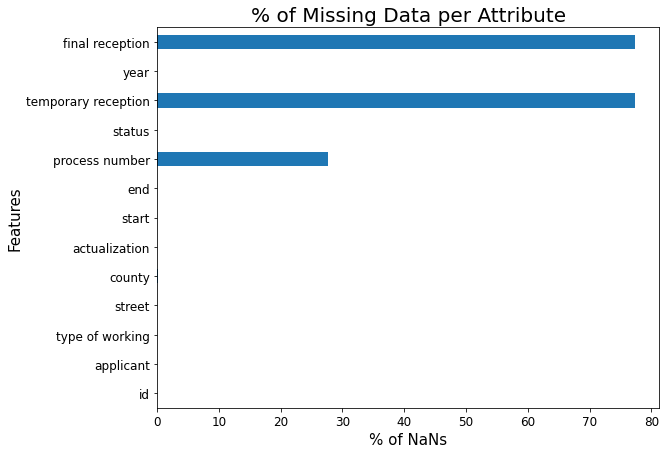

In [12]:
# Check for % of still missing values
missing_values = mnivp.isna().sum()*100/len(mnivp)
missing_values.plot(kind = 'barh', figsize = (9,7), fontsize = 12)
plt.title('% of Missing Data per Attribute', fontsize=20)
plt.ylabel('Features', fontsize = 15)
plt.xlabel('% of NaNs', fontsize = 15)
plt.show()

In [13]:
mnivp.drop(['final reception','temporary reception','process number'], inplace = True, axis = 1)
mnivp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6516 entries, 0 to 6616
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               6516 non-null   int64         
 1   applicant        6516 non-null   object        
 2   type of working  6516 non-null   object        
 3   street           6516 non-null   object        
 4   county           6511 non-null   object        
 5   actualization    6516 non-null   object        
 6   start            6516 non-null   datetime64[ns]
 7   end              6516 non-null   datetime64[ns]
 8   status           6516 non-null   object        
 9   year             6513 non-null   object        
dtypes: datetime64[ns](2), int64(1), object(7)
memory usage: 560.0+ KB


In [14]:
mnivp[mnivp['year'].isna()] 

,id,applicant,type of working,street,county,actualization,start,end,status,year
294,44500340,Particular,Rede eletrica,"Rua dos Eucaliptos, Rua dos Platanos, e Rua da...",U.F. Cascais e Estoril,15-05-2020 10:56,2020-03-09,2020-04-27,Rececao Provisoria (Executado),NaN
326,44751452,EDP,Rede eletrica,"Rua do Pinheiro, Rua do Pinhal, Rua da Vinha e...",U.F. Cascais e Estoril,26-11-2020 17:48,2020-09-08,2020-12-15,Em execucao,NaN
327,44763097,EDP,Rede eletrica,"Rua das Gardenias, Rua de Birre, Estrada da Ma...",U.F. Cascais e Estoril,12-01-2021 15:38,2020-10-12,2021-04-12,Em execucao,NaN


In [15]:
values = {"year": 2020}
mnivp.fillna(values, inplace = True)
mnivp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6516 entries, 0 to 6616
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               6516 non-null   int64         
 1   applicant        6516 non-null   object        
 2   type of working  6516 non-null   object        
 3   street           6516 non-null   object        
 4   county           6511 non-null   object        
 5   actualization    6516 non-null   object        
 6   start            6516 non-null   datetime64[ns]
 7   end              6516 non-null   datetime64[ns]
 8   status           6516 non-null   object        
 9   year             6516 non-null   object        
dtypes: datetime64[ns](2), int64(1), object(7)
memory usage: 560.0+ KB


In [16]:
mnivp[mnivp['county'].isna()] 

,id,applicant,type of working,street,county,actualization,start,end,status,year
1976,39186468,ADC aguas de Cascais,Rede de abastecimento de agua,Rua Dom Diniz Bordalo Pinheiro,NaN,08-03-2017 13:21,2017-03-13,2017-03-24,Em execucao,2017
3237,46632828,ADC aguas de Cascais,Rede de abastecimento de agua,Rua da Mina,NaN,01-05-2021 11:52,2021-03-29,2021-04-03,Rececao Provisoria (Executado),2021
5039,43371210,ADC aguas de Cascais,Rede de abastecimento de agua,Estrada dos Bernardos,NaN,16-05-2018 14:37,2018-05-10,2018-05-10,Rececao Provisoria (Executado),2018
5069,43378176,ADC aguas de Cascais,Rede de abastecimento de agua,Estrada dos Bernardos,NaN,16-05-2018 14:39,2018-05-10,2018-05-10,Rececao Provisoria (Executado),2018
6420,44515589,Particular,Rede eletrica,"Rua Joaquim Ereira, n.� 1610 em Torre",NaN,09-05-2020 21:04,2020-03-30,2020-03-30,Rececao Provisoria (Executado),2020


In [17]:
mnivp[mnivp['street'].isin(['Rua Dom Diniz Bordalo Pinheiro','Rua da Mina','Estrada dos Bernardos', 'Rua Joaquim Ereira, n.� 1610 em Torre'])]

,id,applicant,type of working,street,county,actualization,start,end,status,year
1464,44497889,ADC aguas de Cascais,Rede de abastecimento de agua+residuais,Estrada dos Bernardos,Alcabideche,06-03-2020 09:00,2020-02-16,2020-04-24,Em execucao,2020
1550,44626076,ADC aguas de Cascais,Rede de abastecimento de agua,Estrada dos Bernardos,Alcabideche,06-05-2020 15:11,2020-04-25,2020-05-29,Em execucao,2020
1976,39186468,ADC aguas de Cascais,Rede de abastecimento de agua,Rua Dom Diniz Bordalo Pinheiro,NaN,08-03-2017 13:21,2017-03-13,2017-03-24,Em execucao,2017
2769,44737638,ADC aguas de Cascais,Rede de abastecimento de agua,Estrada dos Bernardos,Alcabideche,26-07-2020 21:00,2020-06-12,2020-06-16,Rececao Provisoria (Executado),2020
3237,46632828,ADC aguas de Cascais,Rede de abastecimento de agua,Rua da Mina,NaN,01-05-2021 11:52,2021-03-29,2021-04-03,Rececao Provisoria (Executado),2021
3761,46905972,ADC aguas de Cascais,Rede de abastecimento de agua,Estrada dos Bernardos,Alcabideche,19-05-2021 07:58,2021-03-30,2021-04-09,Rececao Provisoria (Executado),2021
3922,43899513,ADC aguas de Cascais,Rede de abastecimento de agua,Estrada dos Bernardos,Alcabideche,22-03-2019 14:43,2019-03-10,2019-03-22,Outro,2019
3929,43909308,ADC aguas de Cascais,Rede de abastecimento de agua,Estrada dos Bernardos,Alcabideche,06-05-2019 09:16,2019-05-02,2019-05-09,Em execucao,2019
4005,44306390,ADC aguas de Cascais,Rede de abastecimento de agua,Estrada dos Bernardos,Alcabideche,19-09-2019 08:29,2019-08-28,2019-09-04,Rececao Provisoria (Executado),2019
4329,43406880,Particular,Rede eletrica,Estrada dos Bernardos,Alcabideche,21-08-2018 13:13,2018-08-28,2018-08-28,Em execucao,2018


In [18]:
for ii in range(0, len(mnivp)):
    if mnivp.iloc[ii,3] == 'Estrada dos Bernardos':
        mnivp.iloc[ii,4] = 'Alcabideche'
    if mnivp.iloc[ii,3] == 'Rua Joaquim Ereira, n.� 1610 em Torre':
        mnivp.iloc[ii,4] = 'U.F. Cascais e Estoril'
    if mnivp.iloc[ii,3] == 'Rua Dom Diniz Bordalo Pinheiro':
        mnivp.iloc[ii,4] = 'Other'
    if mnivp.iloc[ii,3] == 'Rua da Mina':
        mnivp.iloc[ii,4] = 'Other'
    if mnivp.iloc[ii,3] == ',Rua do Grupo de Instrucao Popular, n.� 14 em Amoreira':
        mnivp.iloc[ii,3] = 'Rua do Grupo de Instrucao Popular, n.� 14 em Amoreira'

In [19]:
mnivp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6516 entries, 0 to 6616
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               6516 non-null   int64         
 1   applicant        6516 non-null   object        
 2   type of working  6516 non-null   object        
 3   street           6516 non-null   object        
 4   county           6516 non-null   object        
 5   actualization    6516 non-null   object        
 6   start            6516 non-null   datetime64[ns]
 7   end              6516 non-null   datetime64[ns]
 8   status           6516 non-null   object        
 9   year             6516 non-null   object        
dtypes: datetime64[ns](2), int64(1), object(7)
memory usage: 560.0+ KB


In [20]:
# Create off time
mnivp['off'] = (mnivp['end'] - mnivp['start'])/np.timedelta64(1, 'D')
mnivp.head()

,id,applicant,type of working,street,county,actualization,start,end,status,year,off
0,44611945,Particular,Rede eletrica,Rua das Amendoeiras,U.F. Carcavelos e Parede,02-06-2020 09:15,2020-04-24,2020-04-24,Em execucao,2020,0.0
1,44522015,Particular,Rede eletrica,Rua do Bugio,U.F. Carcavelos e Parede,06-04-2020 13:20,2020-04-13,2020-04-14,Em execucao,2020,1.0
2,44514495,Particular,Rede eletrica,Rua das Amendoeiras,U.F. Carcavelos e Parede,12-03-2020 09:38,2020-03-16,2020-03-20,Em execucao,2020,4.0
3,46640212,Particular,Rede eletrica,"Travessa Nuno Tristao, n.1 em Murches",Alcabideche,11-05-2021 15:52,2021-05-18,2021-05-19,Em execucao,2021,1.0
4,40717062,ADC aguas de Cascais,Rede eletrica,Caminho do Uruguai,Alcabideche,24-01-2018 12:13,2018-01-29,2018-02-09,Em execucao,2018,11.0


In [21]:
toplot = pd.DataFrame(mnivp.groupby(by=['off'])['id'].count())
toplot.describe()

,id
count,151.000000
mean,43.152318
std,154.283062
min,1.000000
25%,1.000000
50%,2.000000
75%,9.000000
max,1335.000000


In [22]:
toplot = toplot.reset_index()
toplot

,off,id
0,0.0,892
1,1.0,317
2,2.0,334
3,3.0,176
4,4.0,563
...,...,...
146,1102.0,1
147,1453.0,1
148,1461.0,1
149,1469.0,1


In [23]:
toplot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   off     151 non-null    float64
 1   id      151 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 2.5 KB


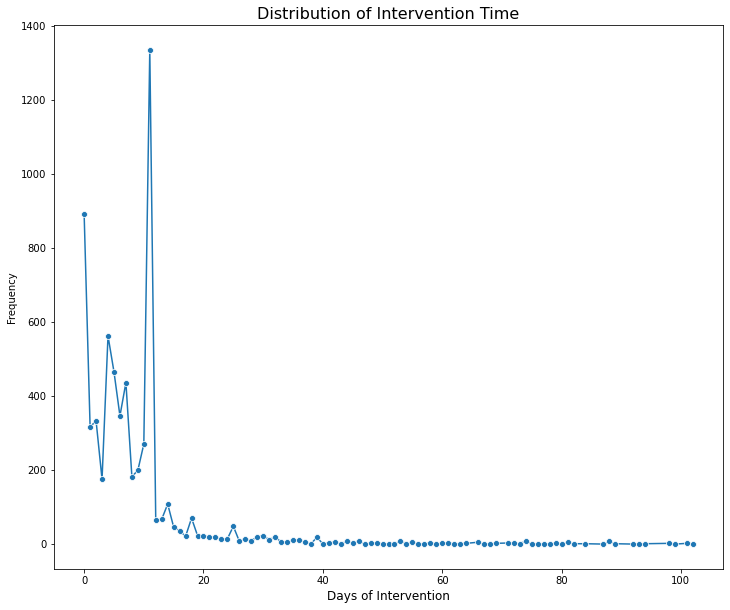

In [24]:
plt.figure(figsize=(12,10))
sns.lineplot(
    x='off',
    y='id',
    data=toplot[toplot['off'] < 103],
    marker = 'o'
)
plt.title('Distribution of Intervention Time', fontsize = 16)
plt.xlabel('Days of Intervention', fontsize = 12)
plt.ylabel('Frequency')
plt.show()

In [25]:
mnivp['off'].describe().round(1)

count    6516.0
mean       13.3
std        68.8
min         0.0
25%         3.0
50%         7.0
75%        11.0
max      3652.0
Name: off, dtype: float64

## How many interventions per street?

**Questions that we have so far:**
1. Which are the streets with more interventions?
2. How many days per year are those streets off?
3. What kind of intervention it was?

In [26]:
np.sort(mnivp['street'].unique())

array(['Alameda Columbano', 'Alameda Duquesa de Palmela',
       'Alameda Duquesa de Palmela em cascais', 'Alameda da Guia',
       'Alameda dos Combatentes da Grande Guerra',
       'Alameda dos Combatentes da Grande Guerra em Cascais',
       'Alameda dos Combatentes da Grande Guerra, Jardim Visconde da Luz em Cascais',
       'Alameda dos Combatentes da Grande Guerra, n.� 247 em Cascais',
       'Alameda dos Combatentes da Grande Guerra, n.� 270 em Cascais',
       'Alameda dos Combatentes da Grande Guerra, n.� 79 em Cascais',
       'Arcadas do Parque Nascente', 'Auto-Estrada A5',
       'Avenida 25 de Abril e Avenida do Ultramar em Cascais',
       'Avenida 25 de Abril em Cascais',
       'Avenida 25 de Abril, 775 em Cascais',
       'Avenida 25 de Abril, hotel cidadela em Cascais',
       'Avenida 25 de Abril, n.� 1011D em Cascais',
       'Avenida 25 de Abril, n.� 1011E em Cascais',
       'Avenida 25 de Abril, n.� 1111 em Cascais',
       'Avenida 25 de Abril, n.� 181 C em Casc

In [30]:
mnivp['street'] = mnivp['street'].str.split(pat=",", expand = True)
np.sort(mnivp['street'].unique())

array(['Alameda Columbano', 'Alameda Duquesa de Palmela',
       'Alameda Duquesa de Palmela em cascais', 'Alameda da Guia',
       'Alameda dos Combatentes da Grande Guerra',
       'Alameda dos Combatentes da Grande Guerra em Cascais',
       'Arcadas do Parque Nascente', 'Auto-Estrada A5',
       'Avenida 25 de Abril',
       'Avenida 25 de Abril e Avenida do Ultramar em Cascais',
       'Avenida 25 de Abril em Cascais', 'Avenida Aida',
       'Avenida Amalia Rodrigues', 'Avenida Amaral',
       'Avenida Ana Rita Abreu Pereira', 'Avenida Antonio Arroio',
       'Avenida Aristides de Sousa Mendes', 'Avenida Bartolomeu Dias',
       'Avenida Bartolomeu Dias em Bairro Rosario', 'Avenida Biarritz',
       'Avenida Castelhana', 'Avenida Clotilde',
       'Avenida Comandante Gilberto Duarte e Duarte',
       'Avenida Conde de Barcelona em Estoril',
       'Avenida Condes de Barcelona', 'Avenida Costa',
       'Avenida Costa Pinto', 'Avenida Costa Pinto em Cascais',
       'Avenida Dom Car

In [31]:
mnivp.head()

,id,applicant,type of working,street,county,actualization,start,end,status,year,off
0,44611945,Particular,Rede eletrica,Rua das Amendoeiras,U.F. Carcavelos e Parede,02-06-2020 09:15,2020-04-24,2020-04-24,Em execucao,2020,0.0
1,44522015,Particular,Rede eletrica,Rua do Bugio,U.F. Carcavelos e Parede,06-04-2020 13:20,2020-04-13,2020-04-14,Em execucao,2020,1.0
2,44514495,Particular,Rede eletrica,Rua das Amendoeiras,U.F. Carcavelos e Parede,12-03-2020 09:38,2020-03-16,2020-03-20,Em execucao,2020,4.0
3,46640212,Particular,Rede eletrica,Travessa Nuno Tristao,Alcabideche,11-05-2021 15:52,2021-05-18,2021-05-19,Em execucao,2021,1.0
4,40717062,ADC aguas de Cascais,Rede eletrica,Caminho do Uruguai,Alcabideche,24-01-2018 12:13,2018-01-29,2018-02-09,Em execucao,2018,11.0
